# Exercício Programa PSI3471

Jean Carlos Mello Xavier Faria - 11259628

Leonardo

Primeiramente, será importado as bibliotecas que serão utilizadas durante o programa

In [36]:
import pandas as pd
import numpy as np
import cv2
import math
import sys
import keras
import matplotlib.pyplot as plt

A primeira etapa tem como objetivo alinhas os grãos horizontalmente, para isso, será necessário encontrar o centro de massa e a orientação das imagens do dataset. Para isso ser possível, será utilizada a função findCenterAndOrientation()

In [21]:
def findCenterAndOrientation(src):
    M = cv2.moments(src)
    cen_x = M["m10"]/M["m00"]
    cen_y = M["m01"]/M["m00"]
    theta = 0.5 * math.atan2( 2*M["mu11"], M["mu20"]-M["mu02"]);
    
    return cen_x, cen_y, theta

Para saber se a função findCenterAndOrientation() está funcionando adequadamente e sendo possível rotacionar a imagem, vamos testar com a imagem "Jasmine (2).jpg", uma das imagens do DataSet. Primeramente, vamos ler a imagem e colocar em img.

In [22]:
img = cv2.imread('Jasmine (2).jpg', 0)

Vamos observar como a imagem é antes de ser rotacionada.

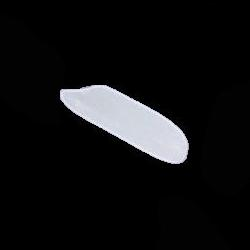

In [23]:
from IPython.display import Image

Image(filename='Jasmine (2).jpg')

Utilizando a função findCenterAndOrientation() nessa imagem, vamos obter os pontos x, y e o ângulo da orientação.

In [24]:
x, y, theta = findCenterAndOrientation(img)
ponto = (x,y)

Para realizar a rotação, vamos utilizar o OpenCV, o método getRotationMatrix2D() e warpAffine(). Como o parâmetro do ângulo para o getRotationMatrix2D() está em graus e a nossa função retorna o valor em radianos, vamos converter o ângulo com a equação básica: $\theta(^o) = 180 \cdot \frac{\theta(rad)}{\pi}$

In [25]:
angulo = 180*theta/math.pi
rotacao = cv2.getRotationMatrix2D(ponto, angulo, 1.0)
rotacionado = cv2.warpAffine(img, rotacao, (len(img[0]), len(img[1])))

Com isso, temos a imagem rotacionada na variável rotacionado. Agora, para podermos visualizar o resultado, vamos passar os valores para uma imagem .png.

In [26]:
cv2.imwrite('white_shape_centered.png',rotacionado)

True

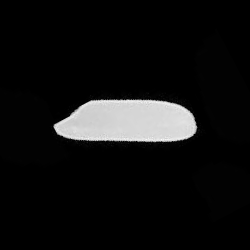

In [27]:
Image(filename='Jasmine (2).png') 

Com isso, temos a imagem Jasmine (2).jpg alinhada horizontalmente. Agora, será necessário realizar esse procidimento em todas as imagens. 

Como as imagens estão escritas como: "nome_do_grão (i).jpg", será criado um array com os nomes dos tipos de grãos que será percorrido por um loop for e dentro desse loop, terá um outro loop para ir de 1 a 1000, conseguindo percorrer todas as imagens. Cada imagem lida será rotacionada, como o procedimento realizado anteriormente, e escrita para uma imagem com o padrão "nome_do_grão (i).png".

In [28]:
rices = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

for rice in rices:
    for num in range(1,1001):
        img = cv2.imread(rice + ' ({}).jpg'.format(num), 0)
        x, y, theta = findCenterAndOrientation(img)
        ponto = (x,y)
        angulo = 180*theta/math.pi
        rotacao = cv2.getRotationMatrix2D(ponto, angulo, 1.0)
        rotacionado = cv2.warpAffine(img, rotacao, (len(img[0]), len(img[1])))
        cv2.imwrite(rice + ' ({}).png'.format(num),rotacionado)

## Parte 2 - Classificar as imagens originais e alinhadas horizontalmente

Após rotacionar as imagens, vamos começar a classificar as imagens. Serão realizadas diversas classificações, com as 25, 50 e 100 primeiras imagens de cada tipo de arroz alinhada horizontalmente e não alinhada horizontalmente, após isso, vamos comparar os valores para saber se a classificação melhorou com o aumento de imagens e se alinhar horizontalmente realmente melhora o desempenho da rede neural. 

Primeiramente, vamos criar uma função para ler a quantidade de imagens que desejamos e se serão as imagens alinhadas ou desalinhadas.

In [29]:
def le(diretorio,nl,nc,inic,fim, alinhada=True):
    nclasses=len(diretorio)
    n=nclasses*(fim-inic+1)
    AX=np.empty((n,nl,nc),np.uint8)
    AY=np.empty((n,),np.uint8)
    j=0; k=0
    for nome in diretorio:
        for i in range(inic,fim+1):
            if alinhada == True:
                st = nome + ' ({}).png'.format(i)
            else:
                st = nome + ' ({}).jpg'.format(i)
            a=cv2.imread(st,0)
            if a is None: print("Erro leitura",st); sys.exit()
            a=cv2.resize(a,(nl,nc),interpolation=cv2.INTER_AREA)
            AX[k,:,:]=a; AY[k]=j
            k+=1
        j+=1
    return AX,AY

Como o objetivo é testar a rede com 25, 50 e 100 primeiras imagens de cada tipo de arroz e isso se divide em imagens que estão alinhadas horizontalmente e imagens não alinhadas, vamos criar um AX e um AY para cada caso e aplicar na nossa rede que será criada posteriormente. Cada imagem será do tamanho 28x28.

Por fim, vamos definir o QX e QY para testar a rede treinada, com as 900 últimas imagens de cada tipo de arroz. 

In [30]:
diretorio=["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]
nl = 28
nc = 28
na = [25, 50, 100]
nclasses = len(diretorio)


AX_25_a, AY_25_a = le(diretorio,nl,nc, 1,na[0], alinhada=True)
AX_50_a, AY_50_a = le(diretorio,nl,nc, 1,na[1], alinhada=True)
AX_100_a, AY_100_a = le(diretorio,nl,nc, 1,na[2], alinhada=True)

AX_25_d, AY_25_d = le(diretorio,nl,nc, 1,na[0], alinhada=False)
AX_50_d, AY_50_d = le(diretorio,nl,nc, 1,na[1], alinhada=False)
AX_100_d, AY_100_d = le(diretorio,nl,nc, 1,na[2], alinhada=False)

AY_25_a = keras.utils.to_categorical(AY_25_a, nclasses)
AY_50_a = keras.utils.to_categorical(AY_50_a, nclasses)
AY_100_a = keras.utils.to_categorical(AY_100_a, nclasses)

AY_25_d = keras.utils.to_categorical(AY_25_d, nclasses)
AY_50_d = keras.utils.to_categorical(AY_50_d, nclasses)
AY_100_d = keras.utils.to_categorical(AY_100_d, nclasses)

QX, QY = le(diretorio, nl, nc, 101, 1000)

QY2 = keras.utils.to_categorical(QY, nclasses)

A rede criada conterá as duas primeiras camadas como camadas convolucionais e as duas últimas como camadas densas. A primeira camada tem o um tamanho 

In [43]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import optimizers
import numpy as np; import sys; import os; from time import time

def NN(AX, AY):
    model = Sequential() # 28x28
    model.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=(nl, nc, 1) )) #20x24x24
    model.add(MaxPooling2D(pool_size=(2,2))) #20x12x12
    model.add(Conv2D(40, kernel_size=(5,5), activation='relu')) #40x8x8
    model.add(MaxPooling2D(pool_size=(2,2))) #40x4x4
    model.add(Flatten()) #640
    model.add(Dense(200, activation='relu')) #200
    model.add(Dense(nclasses, activation='softmax')) #10
    from tensorflow.keras.utils import plot_model
    model.summary()
    opt=optimizers.Adam()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    t0=time()
    history = model.fit(AX, AY, batch_size=100, epochs=30, verbose=1)
    score = model.evaluate(QX, QY2, verbose=False)
    print('\nTest loss: %.4f'%(score[0]))
    print('Test accuracy: %.2f %%'%(100*score[1]))
    print('Test error: %.2f %%'%(100*(1-score[1])))
    t2=time()
    QP2=model.predict(QX); QP=np.argmax(QP2,1)
    t3=time(); print("Tempo de predicao: %.2f s"%(t3-t2))
    nerro=np.count_nonzero(QP-QY); print("nerro=%d"%(nerro))
    return history

Para realizar os treinamentos e os testes, vamos realizar na seguinte sequência: Primeiramente, o 25 alinhado e depois desalinhado, 50 alinhado e desalinhado e, por fim, 100 alinhado e desalinhado. Além disso, vamos gerar um gráfico com o valor das perdas em cada época. 

Portanto, começando com um $n_a = 25$ e alinhado.

In [44]:
history_1 = NN(AX_25_a, AY_25_a)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 640)               0         
                                                                 
 dense_14 (Dense)            (None, 200)              

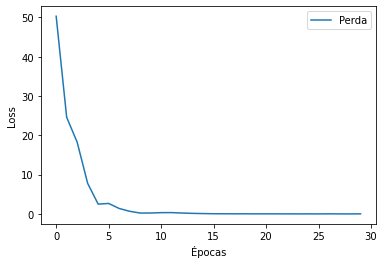

In [45]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Agora para $n_a=25$ com as imagens desalinhadas.

In [46]:
history_2 = NN(AX_25_d, AY_25_d)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 640)               0         
                                                                 
 dense_16 (Dense)            (None, 200)              

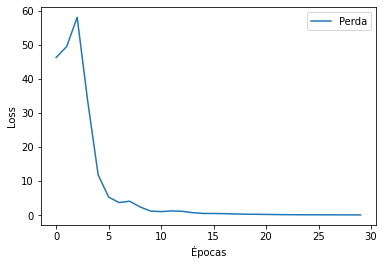

In [47]:
plt.plot(history_2.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Para $n_a=50$ com as imagens alinhadas:

In [48]:
history_3 = NN(AX_50_a, AY_50_a)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 640)               0         
                                                                 
 dense_18 (Dense)            (None, 200)              

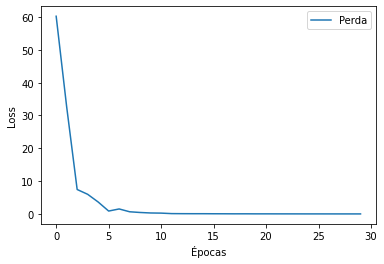

In [49]:
plt.plot(history_3.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Para $n_a = 50$ com as imagens desalinhadas.

In [50]:
history_4 = NN(AX_50_d, AY_50_d)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 640)               0         
                                                                 
 dense_20 (Dense)            (None, 200)             

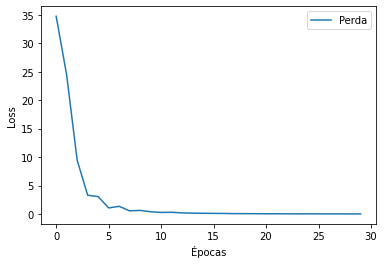

In [51]:
plt.plot(history_4.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Por fim, vamos realizar o treinamento com $n_a = 100$, primeiramente com as imagens alinhadas.

In [52]:
history_5 = NN(AX_100_a, AY_100_a)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 640)               0         
                                                                 
 dense_22 (Dense)            (None, 200)             

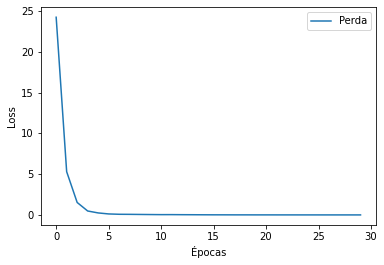

In [53]:
plt.plot(history_5.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Por último $n_a = 100$ com as imagens desalinhadas.

In [54]:
history_6 = NN(AX_100_d, AY_100_d)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 640)               0         
                                                                 
 dense_24 (Dense)            (None, 200)             

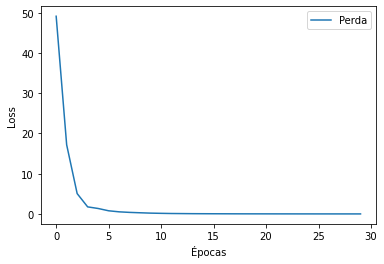

In [55]:
plt.plot(history_6.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Colocando os valores da acurácia dos testes em uma tabela para ser possível observar ao todo os resultados.

$n_a$   | Alinhado  | Desalinhado
--------- | ----------- |----------    
25  | 96,51%      |  94,47% 
50  | 97,87%      |  92,16%
100 | 98,20%      |  93,24%

Como podemos observar, foi possível obter uma acurácia bem maior com as imagens alinhadas horizontalmente em comparação com as imagens diretas do dataset.